In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from datasets import load_dataset
import torch
import torch.nn as nn
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer
import numpy as np
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve,auc
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import DistilBertModel, DistilBertConfig
from sklearn.metrics import classification_report
from nltk.util import ngrams
from gensim.models import Word2Vec
from time import time  # To time our operations
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Flatten,Permute
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow import keras
from tensorflow.keras import layers
from tabnanny import verbose
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import seaborn as sn
from mha import *

In [2]:
emotions = load_dataset('emotion')

emotions.set_format('pandas')
df = emotions['train'][:]
df.head()

def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [3]:
text_list_p=df["text"].tolist()
labels_p=df["label_name"].tolist()

text_list=[]
labels=[]
for i in range(len(labels_p)):
    if text_list_p[i]!='':
        text_list.append(text_list_p[i])
        labels.append(labels_p[i])

labels=np.array(labels)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
num_classes=int(np.max(integer_encoded)+1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
mapping = dict(zip(label_encoder.classes_, onehot_encoder.transform(label_encoder.transform(label_encoder.classes_).reshape(num_classes, 1))))
for key,value in mapping.items():
    print("",key," -----------------------------> ",value)



# randomly create indices for train and test
indices = np.arange(len(text_list))
np.random.shuffle(indices)
splitter=0.6
train_indices = indices[:int(splitter*len(text_list))]
test_indices = indices[int(splitter*len(text_list)):]
text_list_train = np.array(text_list)[train_indices]
text_list_test = np.array(text_list)[test_indices]
labels_train = np.array(labels)[train_indices]
labels_test = np.array(labels)[test_indices]
onehot_encoded_train = np.array(onehot_encoded)[train_indices]
onehot_encoded_test = np.array(onehot_encoded)[test_indices]
integer_encoded_train = np.array(integer_encoded)[train_indices]
integer_encoded_test = np.array(integer_encoded)[test_indices]




# doing for text_list_train
omega_text_words_train = []
n=1
for i in range(len(text_list_train)):
    sentence=text_list_train[i]
    unigrams = ngrams(sentence.split(), n)
    flat_list = [item for sublist in [list(a) for a in unigrams] for item in sublist]
    omega_text_words_train.append(flat_list)


# doing for text_list_test
omega_text_words_test = []
n=1
for i in range(len(text_list_test)):
    sentence=text_list_test[i]
    unigrams = ngrams(sentence.split(), n)
    flat_list = [item for sublist in [list(a) for a in unigrams] for item in sublist]
    omega_text_words_test.append(flat_list)


# doing for text_list
omega_text_words = []
n=1

for i in range(len(text_list)):
    sentence=text_list[i]
    unigrams = ngrams(sentence.split(), n)
    flat_list = [item for sublist in [list(a) for a in unigrams] for item in sublist]
    omega_text_words.append(flat_list)

 anger  ----------------------------->  [1. 0. 0. 0. 0. 0.]
 fear  ----------------------------->  [0. 1. 0. 0. 0. 0.]
 joy  ----------------------------->  [0. 0. 1. 0. 0. 0.]
 love  ----------------------------->  [0. 0. 0. 1. 0. 0.]
 sadness  ----------------------------->  [0. 0. 0. 0. 1. 0.]
 surprise  ----------------------------->  [0. 0. 0. 0. 0. 1.]


In [4]:
t = time()
w2v_model=Word2Vec(sentences=omega_text_words,vector_size=50,window=4,min_count=1,workers=8-1,epochs=60,sg=1) #sh=1->Skip-gram,0->CBOW

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

#As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:
w2v_model.init_sims(replace=True)

Time to train the model: 0.18 mins


ref_embedding_train.shape:  (9600, 66, 50)
ref_embedding_test.shape:  (6400, 64, 50)


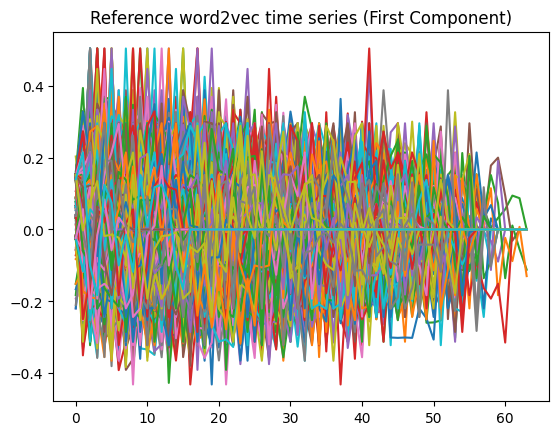

In [5]:
# getting word2vec embedding for train
ref_embedding_train=np.zeros((len(integer_encoded_train),max([len(i) for i in omega_text_words_train]),50))
for i in range(ref_embedding_train.shape[0]):
    sent=omega_text_words_train[i]
    for j in range(len(sent)):
        ref_embedding_train[i,j,:]=w2v_model.wv[omega_text_words_train[i][j]]


# getting word2vec embedding for test
ref_embedding_test=np.zeros((len(integer_encoded_test),max([len(i) for i in omega_text_words_test]),50))
for i in range(ref_embedding_test.shape[0]):
    sent=omega_text_words_test[i]
    for j in range(len(sent)):
        ref_embedding_test[i,j,:]=w2v_model.wv[omega_text_words_test[i][j]]


print("ref_embedding_train.shape: ",ref_embedding_train.shape)
print("ref_embedding_test.shape: ",ref_embedding_test.shape)


plt.figure()
for i in range(len(ref_embedding_test)):
    plt.plot(ref_embedding_test[i,:,0])
    plt.title("Reference word2vec time series (First Component)")     

In [6]:



# creating a tokenizer
t=Tokenizer()
t.fit_on_texts(text_list)
vocab_size = len(t.word_index) + 1




X_encoded_train= t.texts_to_sequences(text_list_train)
X_encoded_test= t.texts_to_sequences(text_list_test)

max_len=max(len(l) for l in X_encoded_train)
print("Maximum  Time series Size in Train Texts:", max_len)

X_train=pad_sequences(X_encoded_train,maxlen=max_len,padding='post')
X_test=pad_sequences(X_encoded_test,maxlen=max_len,padding='post')

y_train=onehot_encoded_train
y_test=onehot_encoded_test


base_size=50
embedding_matrix=np.zeros((vocab_size,base_size))


for word,i in t.word_index.items():
    temp=w2v_model.wv[word]
    if temp is not None:
        embedding_matrix[i]=temp

red_size=base_size
#-----------------------Autoencoder Compression-----------------------#
red_size = 25
random_state = 0
scaler=MinMaxScaler()
# emb_mat1=scaler.fit_transform(embedding_matrix)
emb_mat1=embedding_matrix
acti='relu'
acti_en='tanh'
input_vec = keras.Input(shape=(base_size,))
x = layers.Dense(red_size*4, activation=acti)(input_vec)
x= layers.Dense(red_size*2, activation=acti)(x)
encoded = layers.Dense(red_size, activation=acti_en,name='subversion')(x)
decoded = layers.Dense(red_size*2, activation=acti)(encoded)
decoded = layers.Dense(red_size*4, activation=acti)(decoded)
decoded = layers.Dense(base_size, activation='linear')(decoded)
autoencoder = keras.Model(input_vec, decoded)
autoencoder.compile(optimizer=Adam(lr=1e-4), loss='mse')

autoencoder.fit(emb_mat1, emb_mat1,
                epochs=20,shuffle=True,verbose=1,validation_split=0.2)


encoder = keras.Model(input_vec, encoded)
embedding_matrix=encoder.predict(emb_mat1)


#-----------------------Neural Embedding (Supervised now unlinke previous)-----------------------#

very_red_size=red_size
model=Sequential()
model.add(Embedding(vocab_size,red_size,weights=[embedding_matrix],input_length=max_len,trainable=True,name='embedder'))
# model.add(LayerNormalization())
# model.add(Dense(very_red_size,activation='linear',name='getter'))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(20,activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(num_classes,activation='softmax'))
model.compile(optimizer=Adam(lr=1e-3),loss='categorical_crossentropy',metrics=['acc'])
model.summary()
history=model.fit(X_train,y_train,epochs=40,verbose=2,batch_size=32,validation_data=(X_test,y_test))

Maximum  Time series Size in Train Texts: 66



Epoch 1/20



381/381 [==============================] - 2s 2ms/step - loss: 0.0084 - val_loss: 0.0039
Epoch 2/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 3/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 4/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 5/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 6/20
381/381 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 7/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 8/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 9/20
381/381 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 10/20
381/381 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 11/2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        (None, 66, 25)            380325    
                                                                 
 dropout (Dropout)           (None, 66, 25)            0         
                                                                 
 flatten (Flatten)           (None, 1650)              0         
                                                                 
 dense_5 (Dense)             (None, 20)                33020     
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 126       
                                                                 
Total params: 413471 (1.58 MB)
Trainable params: 413471 

300/300 - 2s - loss: 1.5847 - acc: 0.3396 - val_loss: 1.5526 - val_acc: 0.4245 - 2s/epoch - 6ms/step
Epoch 2/40
300/300 - 1s - loss: 1.4730 - acc: 0.4093 - val_loss: 1.3764 - val_acc: 0.4939 - 1s/epoch - 4ms/step
Epoch 3/40
300/300 - 1s - loss: 1.1816 - acc: 0.5671 - val_loss: 1.0810 - val_acc: 0.6383 - 1s/epoch - 4ms/step
Epoch 4/40
300/300 - 1s - loss: 0.8183 - acc: 0.7048 - val_loss: 0.8387 - val_acc: 0.7156 - 1s/epoch - 4ms/step
Epoch 5/40
300/300 - 1s - loss: 0.5925 - acc: 0.7949 - val_loss: 0.7525 - val_acc: 0.7520 - 1s/epoch - 4ms/step
Epoch 6/40
300/300 - 1s - loss: 0.4347 - acc: 0.8545 - val_loss: 0.6727 - val_acc: 0.7792 - 1s/epoch - 4ms/step
Epoch 7/40
300/300 - 1s - loss: 0.3250 - acc: 0.8916 - val_loss: 0.6701 - val_acc: 0.7814 - 1s/epoch - 3ms/step
Epoch 8/40
300/300 - 1s - loss: 0.2484 - acc: 0.9174 - val_loss: 0.6527 - val_acc: 0.7944 - 1s/epoch - 4ms/step
Epoch 9/40
300/300 - 1s - loss: 0.1894 - acc: 0.9402 - val_loss: 0.6812 - val_acc: 0.7930 - 1s/epoch - 4ms/step
Epo

In [7]:
layer_output=model.get_layer('embedder').output
intermediate_model=keras.models.Model(inputs=model.input,outputs=layer_output)
intermediate_prediction_train=intermediate_model.predict(X_train)
scaler=100.0
rough_timeseries_train=scaler*intermediate_prediction_train
print("Train rough time series shape: ",rough_timeseries_train.shape)


intermediate_prediction_test=intermediate_model.predict(X_test)
scaler=100.0
rough_timeseries_test=scaler*intermediate_prediction_test
print("Test rough time series shape: ",rough_timeseries_test.shape)

300/300 [==============================] - 0s 1ms/step
Train rough time series shape:  (9600, 66, 25)
200/200 [==============================] - 0s 798us/step
Test rough time series shape:  (6400, 66, 25)


In [8]:
max_size=max([len(i) for i in omega_text_words])+200

# TRAIN 

time_stretched_train=np.zeros((len(y_train),max_size,very_red_size)) #stretches the vector over zero padding
time_stretched2_train=np.zeros((len(y_train),max_size,very_red_size)) #stretches the vector over zero padding but also stretches 
                                                            # a scalar over whole zero padding

for i in range(len(y_train)):
    data=rough_timeseries_train[i]
    indo=omega_text_words_train[i]
    sub_data=data[:len(omega_text_words_train[i]),:]
    if (len(indo)>1):
        data_stretched=np.zeros((max_size,very_red_size))
        for k in range(data_stretched.shape[1]):
            strectchy=librosa.resample(sub_data[:,k], sub_data.shape[0], max_size)
            data_stretched[:,k]=strectchy[:max_size]

        time_stretched_train[i,:,:]=data_stretched
        time_stretched2_train[i,:,:]=data_stretched

    if (len(indo)==1):
        sub_data_val=sub_data[:,:very_red_size]
        time_stretched_train[i,:sub_data_val.shape[0],:]=sub_data_val

        data_stretched=np.zeros((max_size,very_red_size))

        for k in range(data_stretched.shape[1]):
            stretchy=librosa.core.resample(sub_data_val[:,k], sub_data_val.shape[0], max_size)
            data_stretched[:,k]=strectchy[:max_size]

        time_stretched2_train[i,:,:]=data_stretched


# TEST

time_stretched_test=np.zeros((len(y_test),max_size,very_red_size)) #stretches the vector over zero padding
time_stretched2_test=np.zeros((len(y_test),max_size,very_red_size)) #stretches the vector over zero padding but also stretches

for i in range(len(y_test)):
    data=rough_timeseries_test[i]
    indo=omega_text_words_test[i]
    sub_data=data[:len(omega_text_words_test[i]),:]
    if (len(indo)>1):
        data_stretched=np.zeros((max_size,very_red_size))
        for k in range(data_stretched.shape[1]):
            strectchy=librosa.core.resample(sub_data[:,k], sub_data.shape[0], max_size)
            data_stretched[:,k]=strectchy[:max_size]

        time_stretched_test[i,:,:]=data_stretched
        time_stretched2_test[i,:,:]=data_stretched

    if (len(indo)==1):
        sub_data_val=sub_data[:,:very_red_size]
        time_stretched_test[i,:sub_data_val.shape[0],:]=sub_data_val

        data_stretched=np.zeros((max_size,very_red_size))

        for k in range(data_stretched.shape[1]):
            stretchy=librosa.core.resample(sub_data_val[:,k], sub_data_val.shape[0], max_size)
            data_stretched[:,k]=strectchy[:max_size]

        time_stretched2_test[i,:,:]=data_stretched


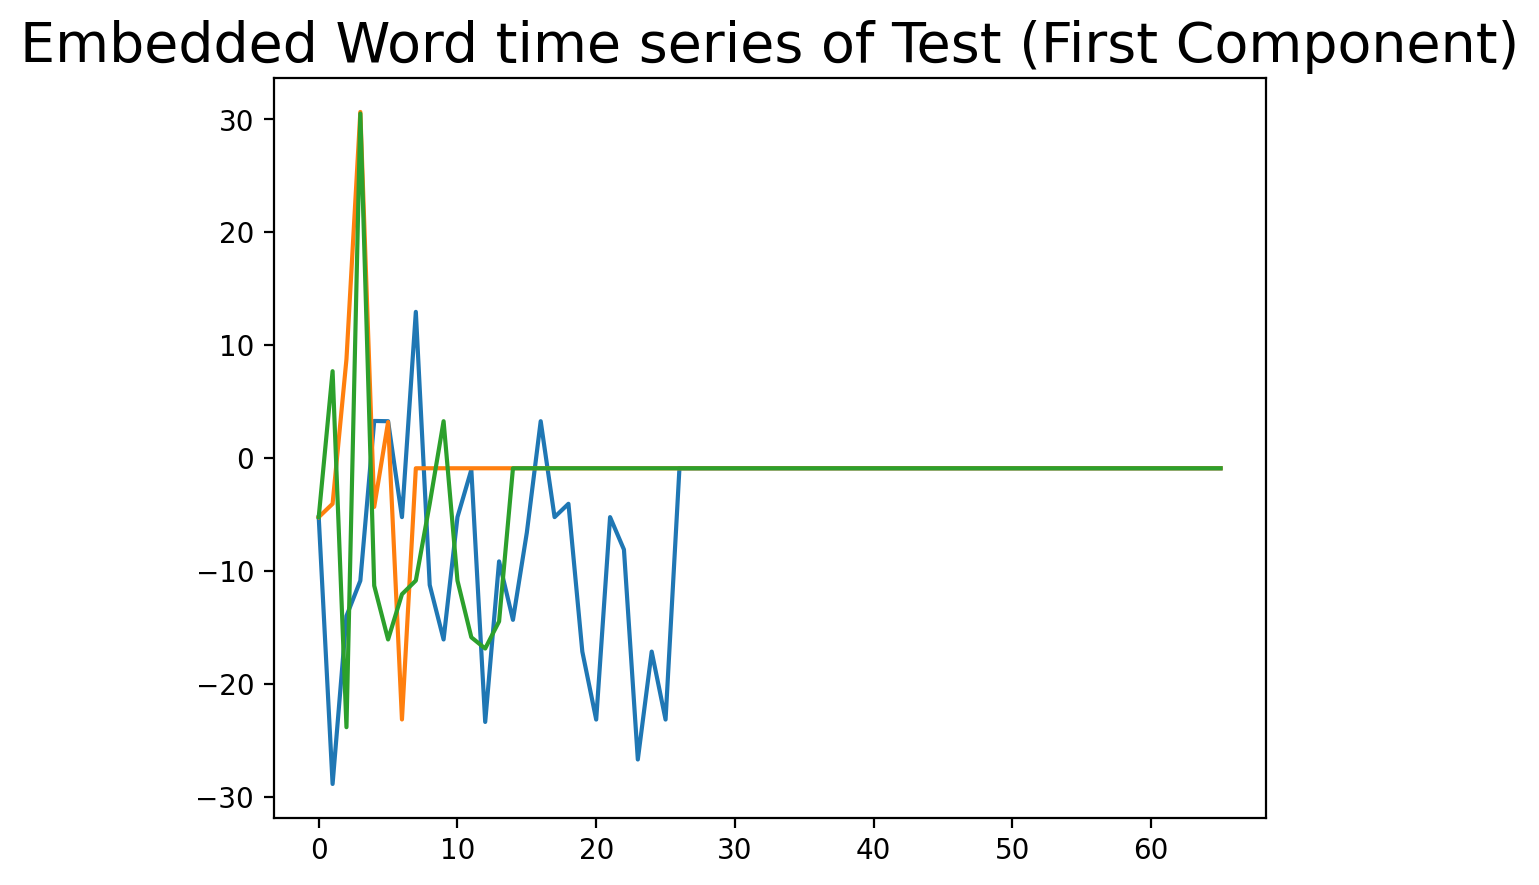

In [9]:
plt.figure(dpi=200)
for i in [3,4,5]:
    plt.plot(rough_timeseries_test[i,:,0])
    plt.title("Embedded Word time series of Test (First Component)", fontsize=20)

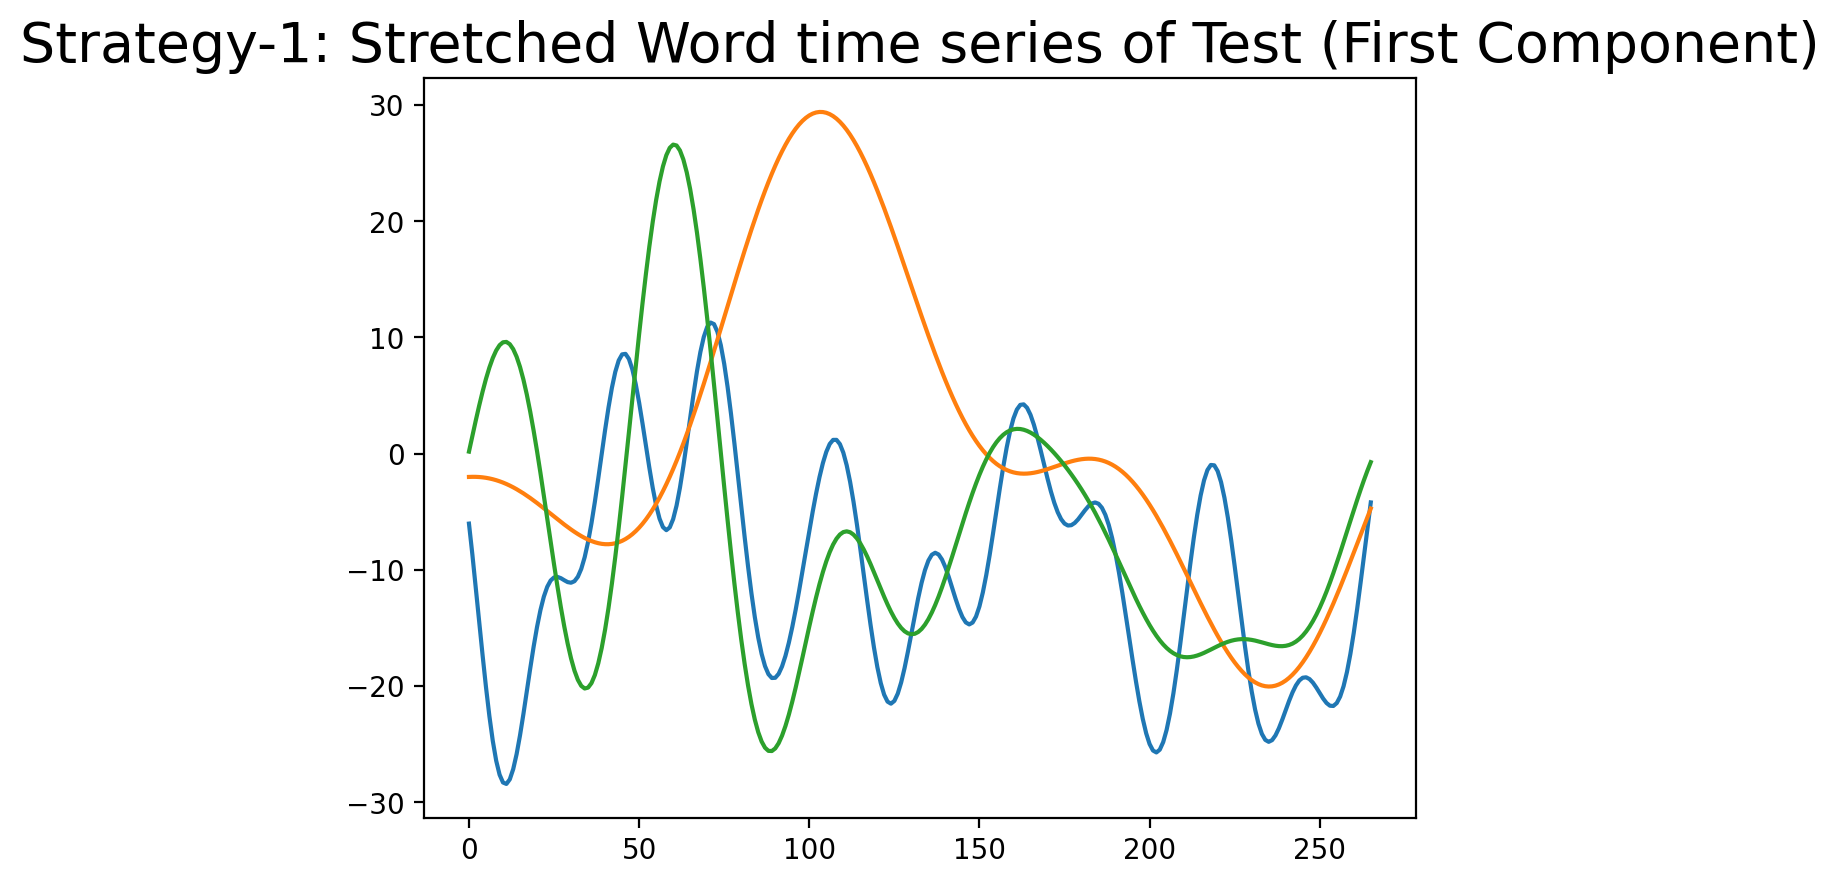

In [10]:
plt.figure(dpi=200)
for i in [3,4,5]:
    plt.plot(time_stretched_test[i,:,0])
    plt.title("Strategy-1: Stretched Word time series of Test (First Component)", fontsize=20)

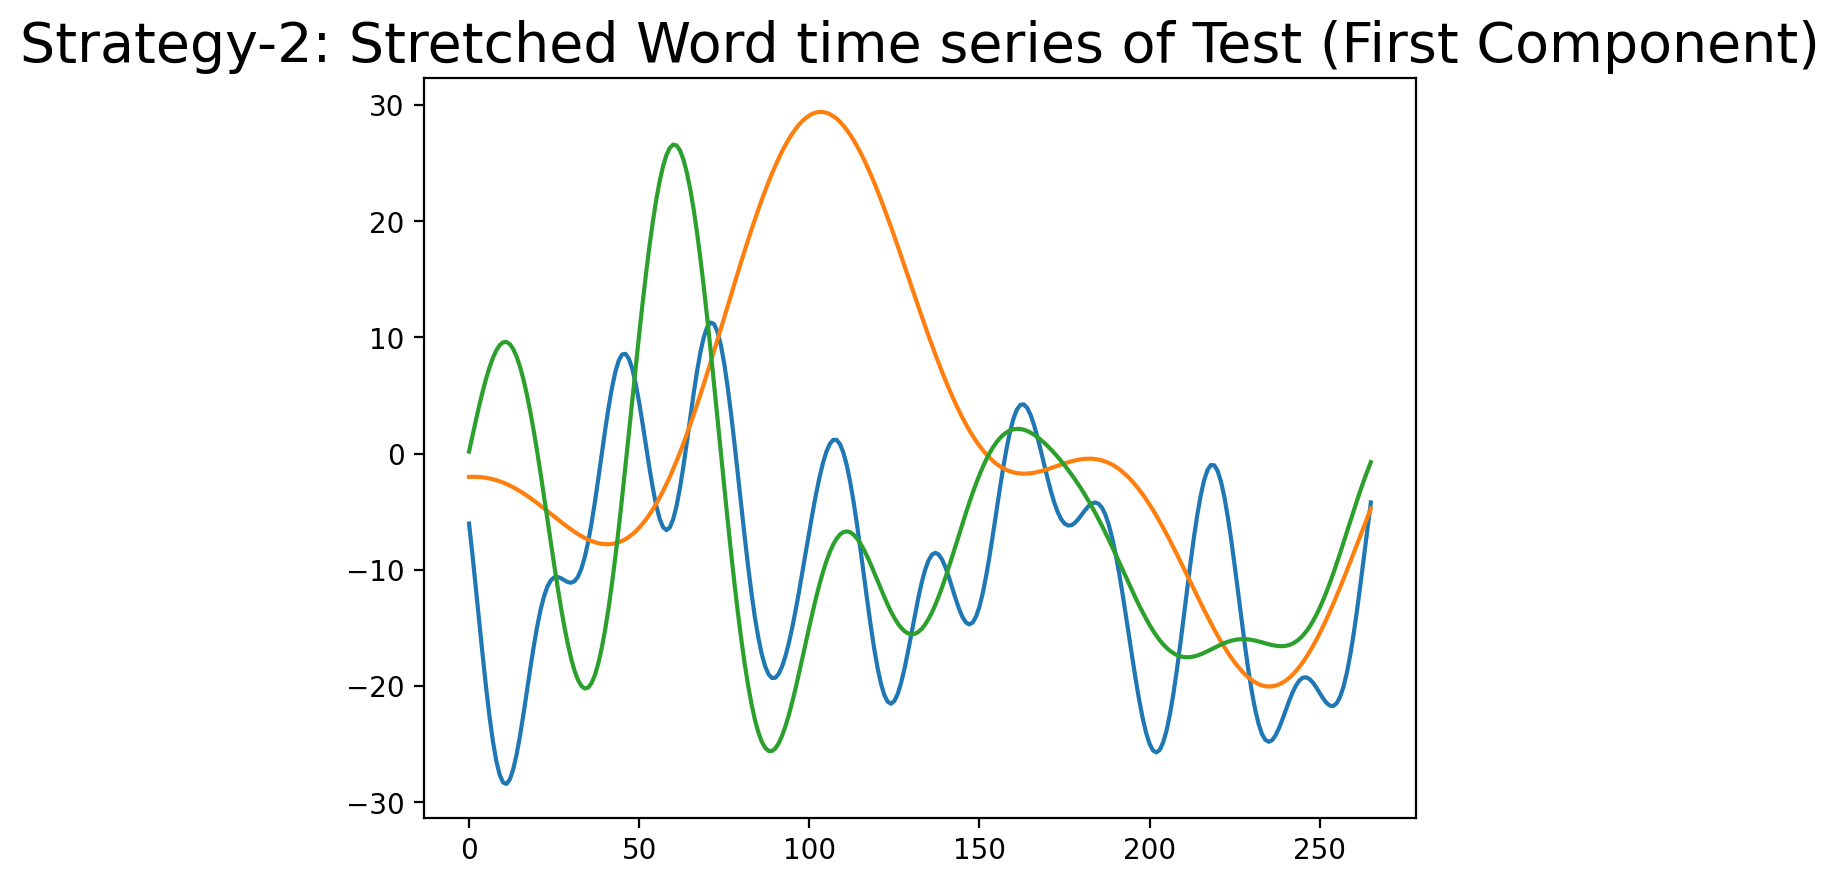

In [11]:
plt.figure(dpi=200)
for i in [3,4,5]:
    plt.plot(time_stretched2_test[i,:,0])
    plt.title("Strategy-2: Stretched Word time series of Test (First Component)", fontsize=20)

In [12]:
print("Train Signal Features Shape: ",time_stretched2_train.shape)
print("Test Signal Features Shape: ",time_stretched2_test.shape)

Train Signal Features Shape:  (9600, 266, 25)
Test Signal Features Shape:  (6400, 266, 25)


In [16]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    output = []
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # outputs = torch.squeeze(outputs)  
            targets = targets.squeeze(1)
            # Convert outputs to predicted labels
            predicted_labels = torch.argmax(outputs, dim=1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())
            output.extend(outputs.cpu().numpy())


    true_labels, predictions = y_true,y_pred
    # Convert lists to numpy arrays
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

In [14]:
# create a tensor dataset
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(time_stretched2_train),torch.Tensor(integer_encoded_train))
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(time_stretched2_test),torch.Tensor(integer_encoded_test))

# create a data loader
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)


In [29]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class TransformerEncoder(nn.Module):
    def __init__(self, embed_size, num_heads, ff_dim, dropout=0):
        super(TransformerEncoder, self).__init__()
        self.norm1 = nn.LayerNorm(embed_size, eps=1e-6) # takes input of shape (batch, sentence_length, embedding_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, dropout=dropout)   # processes (seq_len, batch_size, embed_size (features or channels))
        # self.self_attention = MultiHeadedAttention(embed_size=embed_size, heads=num_heads, dropout_rate=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(embed_size, eps=1e-6)
        self.feed_forward = nn.Sequential(
            nn.Conv1d(embed_size, ff_dim, kernel_size=1),    #processes (batch_size, embed_size (features or channels), seq_len)
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(ff_dim, embed_size, kernel_size=1),
            nn.Dropout(dropout)
        )

    def forward(self, inputs):
        x = self.norm1(inputs)
        x = x.permute(1, 0, 2)
        x, _ = self.self_attention(x, x, x)
        # x = self.self_attention(x, x, x, None)  # No mask is used here
        x = x.permute(1, 0, 2)
        x = self.dropout1(x)
        res = x + inputs
        x = self.norm2(res)
        x=self.feed_forward(x.permute(0,2,1)).permute(0,2,1)
        return x + res

class TransformerModel(nn.Module):
    def __init__(self, embed_size, num_heads, ff_dim, num_transformer_blocks, dropout, dense_width, num_classes):
        super(TransformerModel, self).__init__()
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoder(embed_size, num_heads, ff_dim, dropout) for _ in range(num_transformer_blocks)
        ])
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.batch_norm1 = nn.BatchNorm1d(embed_size)
        self.fc1 = nn.Linear(embed_size, dense_width)
        self.batch_norm2 = nn.BatchNorm1d(dense_width)
        self.fc2 = nn.Linear(dense_width, num_classes)

    def forward(self, x):
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
  
        x = x.permute(0, 2, 1)  # (batch, seq_len, embed_size(features or channels)) to (batch, embed_size, seq_len)
        x= self.pooling(x)
        x = x.squeeze(-1)
        # x = self.pooling(x.permute(0, 2, 1)).squeeze(2)
        x = self.batch_norm1(x)
        x = torch.relu(self.fc1(x))
        x = self.batch_norm2(x)
        x = self.fc2(x)
        return x


embed_size = time_stretched2_train.shape[-1]   # features or channels dim
num_heads = 5                 # number of heads (divisor of embed_size)
ff_dim = 32                   # feed forward dimension
num_transformer_blocks = 3    # number of transformer blocks
dropout = 0.2                 # dropout rate
n_classes = onehot_encoded_train.shape[-1]             # number of classes
dense_width = 20

model = TransformerModel( 
                        embed_size=embed_size,
                        num_heads=num_heads,
                        ff_dim=ff_dim,
                        num_transformer_blocks=num_transformer_blocks,
                        dropout=dropout,
                        dense_width=dense_width, 
                        num_classes=n_classes).to(device)

# Example optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()
total_epochs= 3
for epoch in range(total_epochs):
    run_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        y=y.squeeze(1)
        loss = loss_function(y_pred, y.long())
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    run_loss /= len(train_loader)
    if epoch % 1 == 0:
        print('Epoch: {}/{}, Loss: {:.4f}'.format(epoch+1, total_epochs, run_loss))
        accuracy, f1, precision, recall = evaluate_model(model, train_loader, device)
        print('||Train|| Accuracy: {:.4f}, F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}'.format(accuracy, f1, precision, recall))
        accuracy, f1, precision, recall = evaluate_model(model, test_loader, device)
        print('||Test|| Accuracy: {:.4f}, F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}'.format(accuracy, f1, precision, recall))
        model.train()
        print("---------------------------------------------------------------------------------------------------------")


Epoch: 1/3, Loss: 0.6916
||Train|| Accuracy: 0.9651, F1: 0.9650, Precision: 0.9651, Recall: 0.9649
||Test|| Accuracy: 0.8709, F1: 0.8694, Precision: 0.8709, Recall: 0.8692
---------------------------------------------------------------------------------------------------------
Epoch: 2/3, Loss: 0.1724
||Train|| Accuracy: 0.9726, F1: 0.9726, Precision: 0.9726, Recall: 0.9726
||Test|| Accuracy: 0.8848, F1: 0.8836, Precision: 0.8848, Recall: 0.8839
---------------------------------------------------------------------------------------------------------
Epoch: 3/3, Loss: 0.1217
||Train|| Accuracy: 0.9784, F1: 0.9787, Precision: 0.9784, Recall: 0.9785
||Test|| Accuracy: 0.8833, F1: 0.8839, Precision: 0.8833, Recall: 0.8831
---------------------------------------------------------------------------------------------------------


<Axes: >

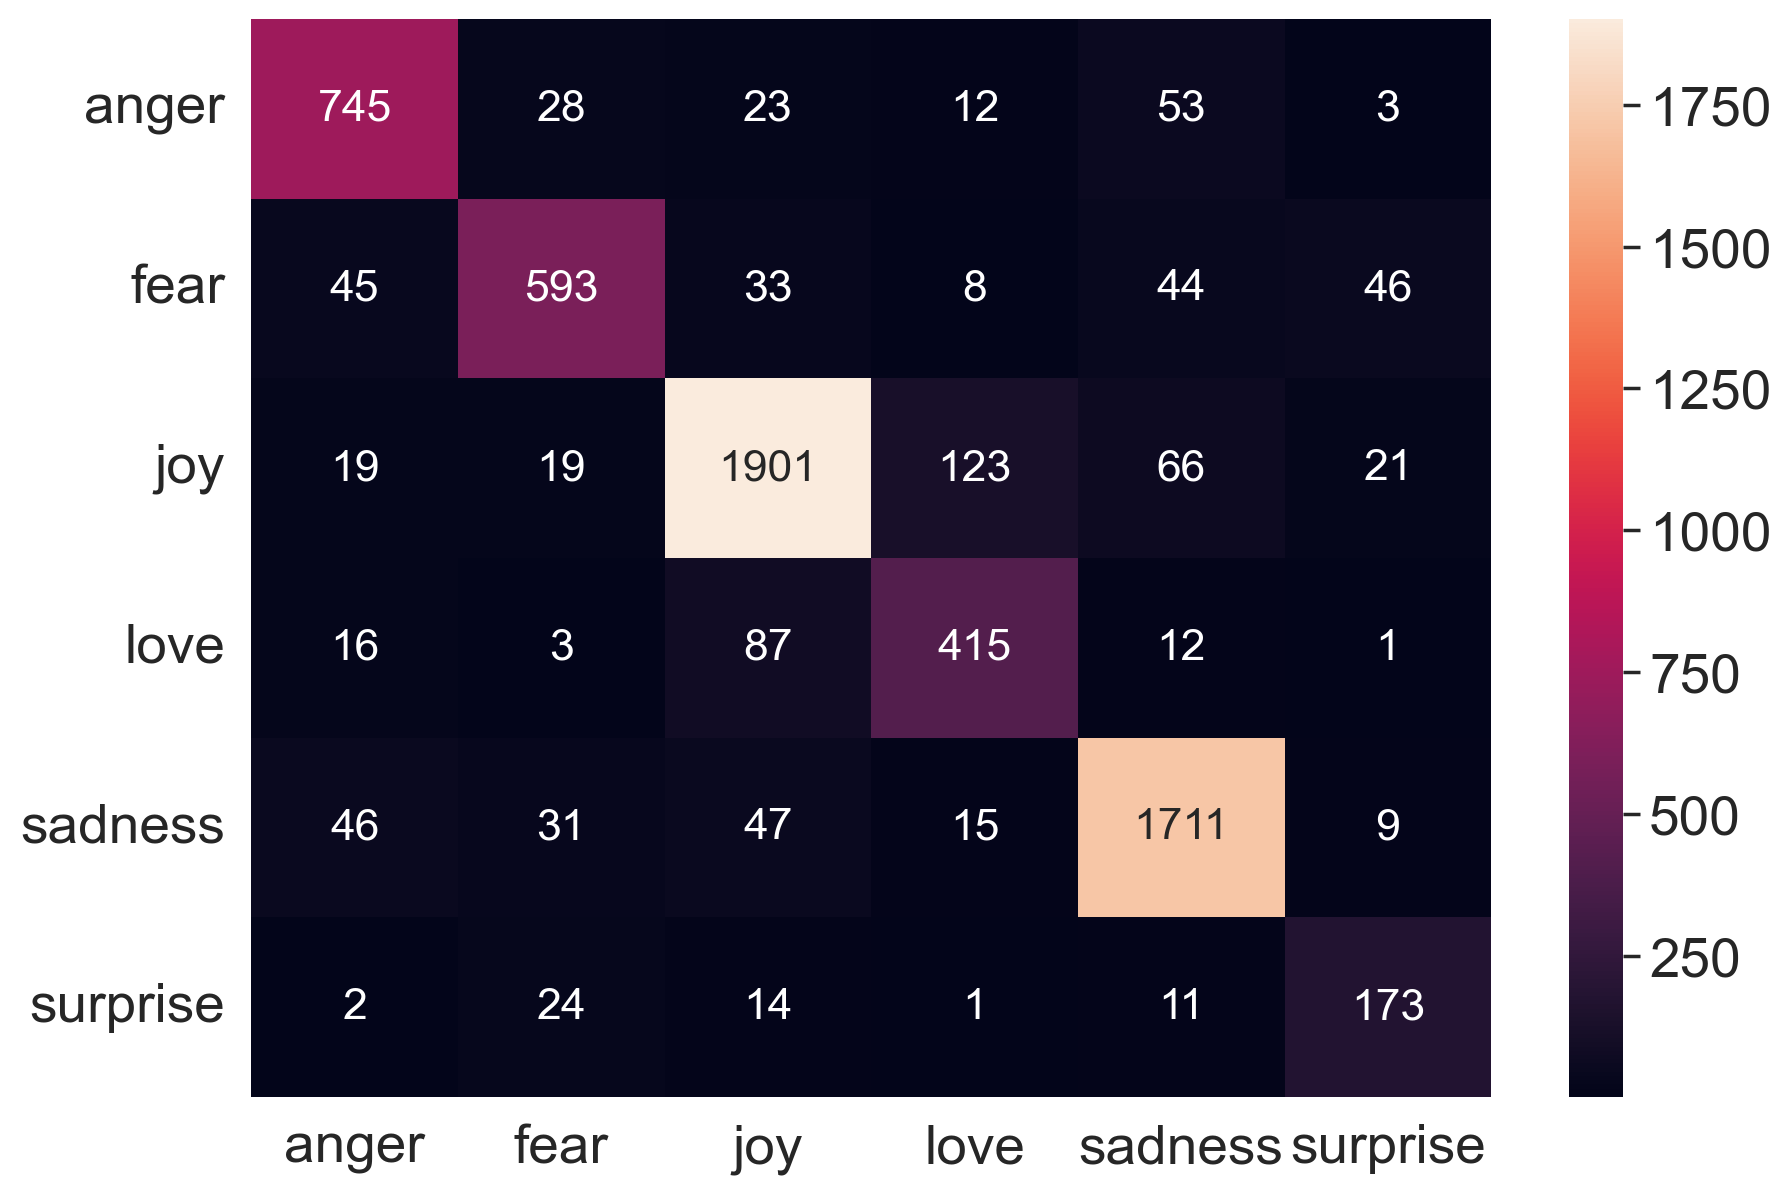

In [30]:
ref=[]
predictions=[]
for batch in test_loader:
    x, targets = batch
    x = x.to(device)
    targets = targets.to(device)
    outputs = model(x)
    # outputs = torch.squeeze(outputs)
    targets = targets.squeeze(1).long()
    predicted_labels = torch.argmax(outputs, dim=1)
    ref.extend(targets.cpu().numpy())
    predictions.extend(predicted_labels.cpu().numpy())



cm=confusion_matrix(ref,predictions)


label_names=[]
for key,_ in mapping.items():
    label_names.append(key)

    
#plot confusion matrix

df_cm = pd.DataFrame(cm, label_names,label_names)
plt.figure(figsize = (10,7),dpi=200)
sn.set(font_scale=1.8)  # Increase the font size for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='d') # font size

In [31]:
print(classification_report(ref, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.8534    0.8623    0.8578       864
           1     0.8496    0.7711    0.8085       769
           2     0.9031    0.8846    0.8937      2149
           3     0.7230    0.7772    0.7491       534
           4     0.9020    0.9204    0.9111      1859
           5     0.6838    0.7689    0.7238       225

    accuracy                         0.8653      6400
   macro avg     0.8191    0.8307    0.8240      6400
weighted avg     0.8669    0.8653    0.8656      6400

